# HW4 - MobileNet V1 and V2: A PyTorch Tutorial
[CE40477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Author__: Amirmahdi Meighani



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 and V2 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 and V2 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 and V2
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 and V2 in PyTorch
- Use transfer learning for better accuracy


In [2]:
# Enter your information here
first_and_last_name = 'Sina'
std_number = 'Beyrami'

![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [29]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader


Check your device. We recommend using GPU. You can use GPU with google colab.

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [5]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float): Scale parameter.
        beta (float): Shift parameter.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    mean = np.mean(x, axis=0)
    variance = np.var(x, axis=0)

    x_normalized = (x - mean) / np.sqrt(variance + epsilon)

    y = gamma * x_normalized + beta

    return y


In [6]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [54]:
# TRANSFORMS
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])




# TRAIN DATA
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# TODO: create train data loader without shuffle with just half of the data
train_indices = list(range(len(train_set) // 2))
train_subset = Subset(train_set, train_indices)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=False)


# VALIDATION DATA
val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# TODO: create test
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

print(len(train_loader), len(val_loader))

Files already downloaded and verified
Files already downloaded and verified
391 157


Explain what we did in transfor train and tranform test:<br/>
- `transform_train`:
  - Purpose: Prepares training data with augmentations to improve model generalization.
  - Steps:
    1. Randomly crop and resize images to 224x224 pixels.
    2. Randomly flip images horizontally.
    3. Convert images to PyTorch tensors.
    4. Normalize images using the dataset's mean and standard deviation.

- `transform_test`:
  - Purpose: Prepares test data for consistent evaluation.
  - Steps:
    1. Resize images to 224x224 pixels.
    2. Convert images to PyTorch tensors.
    3. Normalize images using the same mean and standard deviation as training data.

This ensures data augmentation for training and standardization for testing.

for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.

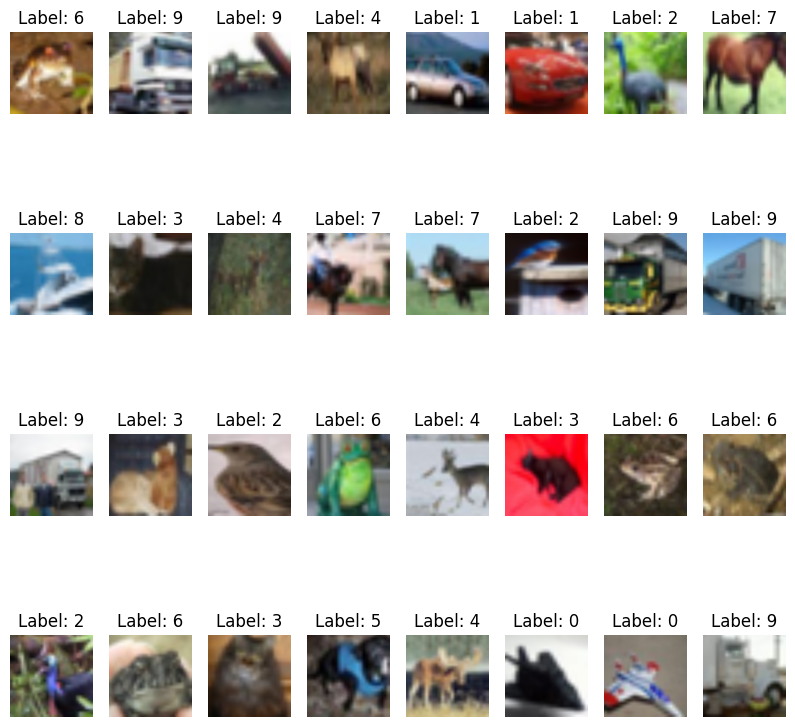

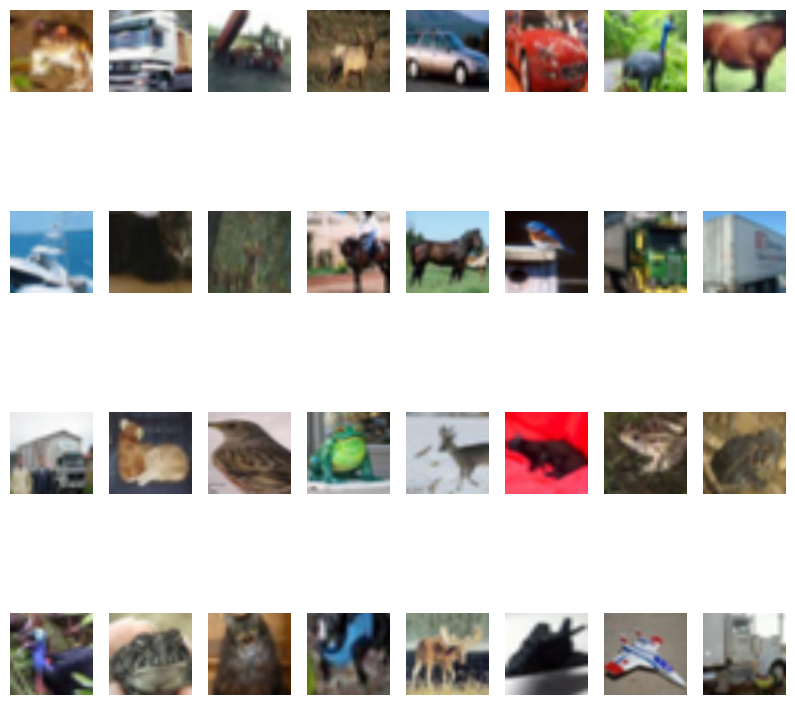


Labels for original images are: tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9]) 



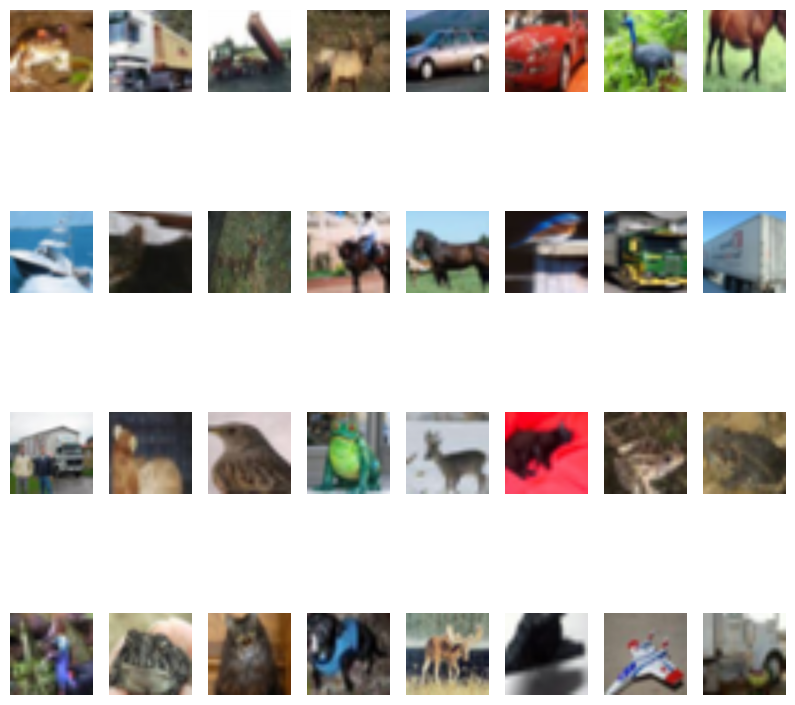


Labels for augmented images are: tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9]) 



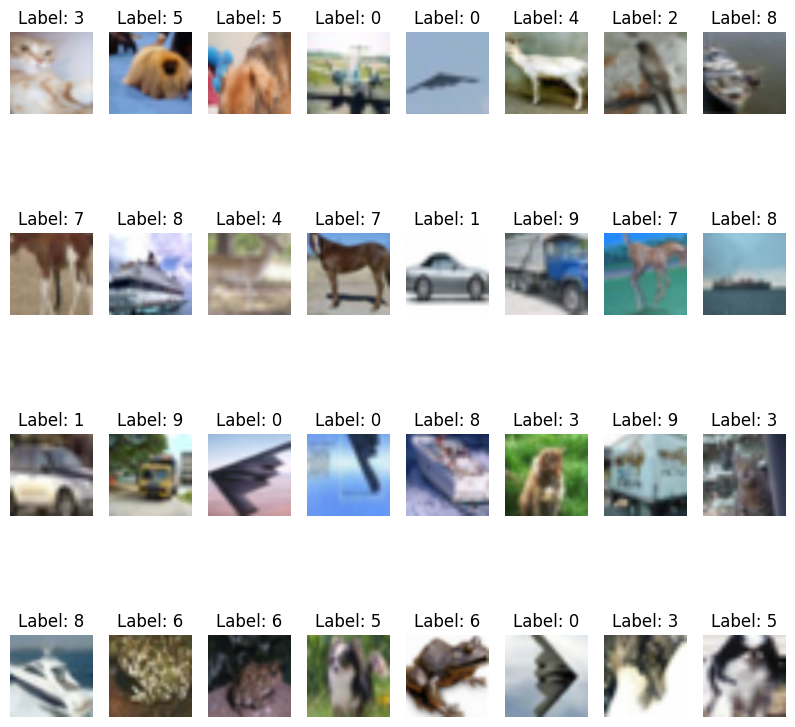

In [8]:
def imshow(img):
    # TODO:
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')


train_loader_unshuffled = DataLoader(train_subset, batch_size=32, shuffle=False)

dataiter = iter(train_loader_unshuffled)
images, labels = next(dataiter)

plt.figure(figsize=(10, 10))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    imshow(images[i])
    plt.title(f"Label: {labels[i]}")
plt.show()

# show some training images with shuffle=False and labels
train_loader_unshuffled = DataLoader(train_subset, batch_size=32, shuffle=False)

dataiter = iter(train_loader_unshuffled)
images, labels = next(dataiter)

plt.figure(figsize=(10, 10))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    imshow(images[i])
plt.show()

print("\nLabels for original images are:", labels, "\n")

# show them again to check the augmentation
train_loader_augmented = DataLoader(train_subset, batch_size=32, shuffle=False)

dataiter_aug = iter(train_loader_augmented)
images_aug, labels_aug = next(dataiter_aug)

plt.figure(figsize=(10, 10))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    imshow(images_aug[i])
plt.show()

print("\nLabels for augmented images are:", labels_aug, "\n")


# create train loader with shuffle true
train_loader_shuffled = DataLoader(train_subset, batch_size=32, shuffle=True)

dataiter_aug = iter(train_loader_shuffled)
images_aug, labels_aug = next(dataiter_aug)

plt.figure(figsize=(10, 10))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    imshow(images_aug[i])
    plt.title(f"Label: {labels_aug[i]}")
plt.show()

For trainig our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [9]:
MODEL_SAVE_PATH = './model.pt'


# Assuming global variables 'device' and 'MODEL_SAVE_PATH' are defined elsewhere.

def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        List[float]: List of losses for the epoch.
    """
    model.train() if train_mode else model.eval()
    epoch_losses = []
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad() if train_mode else None

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        epoch_losses.append(loss.item())

        if train_mode:
            loss.backward()
            optimizer.step()
    return epoch_losses



def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        train_epoch_losses = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        train_losses.append(sum(train_epoch_losses) / len(train_epoch_losses))
        val_epoch_losses = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)
        val_losses.append(sum(val_epoch_losses) / len(val_epoch_losses))
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")

    return train_losses, val_losses



def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        float: Validation accuracy.
    """
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    return correct / total



def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
    smoothed_train_losses = [
        sum(train_losses[max(0, i - c_window):i + 1]) / (i - max(0, i - c_window) + 1)
        for i in range(len(train_losses))
    ]
    plt.plot(smoothed_train_losses, label="Train Loss (Smoothed)")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Losses")
    plt.show()


Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [10]:
def conv_bn(inp, oup, stride):
    # Define a standard convolutional layer with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the convolution
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

def conv_dw(inp, oup, stride):
    # Define a depthwise separable convolution layer
    # Consists of depthwise convolution followed by pointwise convolution, each with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the depthwise convolution
    return nn.Sequential(
        nn.Conv2d(inp, inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters(calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.


- **Depthwise Separable Convolutions** split a standard convolution into:
  1. **Depthwise Convolution:** Applies one filter per input channel.
  2. **Pointwise Convolution:** Combines depthwise outputs using \(1 * 1\) convolutions.

---

- **Parameter Comparison:**
  - **Standard Convolution Parameters:**

        P(standard) = K * K * M * N

  - **Depthwise Separable Convolution Parameters:**
        P_(depthwise separable) = K * K * M + M * N
  - For \(K = 3\), \(M = 32\), \(N = 64\):
    - Standard: \(18,432\) parameters.
    - Depthwise Separable: \(2,336\) parameters (~87% reduction).

---

- **Efficiency:**
  - Reduces parameters and computations significantly.
  - Makes models faster and more memory-efficient, ideal for mobile devices.

Now please create your model.

In [11]:
class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        super(MobileNet, self).__init__()

        self.model = nn.Sequential(
            conv_bn(3, 32, stride=2),
            conv_dw(32, 64, stride=1),
            conv_dw(64, 128, stride=2),
            conv_dw(128, 128, stride=1),
            conv_dw(128, 256, stride=2),
            conv_dw(256, 256, stride=1),
            conv_dw(256, 512, stride=2),

            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),

            conv_dw(512, 1024, stride=2),
            conv_dw(1024, 1024, stride=1),

            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)  # Fully connected layer
        return x

Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

Epoch 1/10, Train Loss: 1.6295343027700244, Val Loss: 1.4981811342725329
Epoch 2/10, Train Loss: 1.27349692278201, Val Loss: 1.0880756773007143
Epoch 3/10, Train Loss: 1.0731994245973084, Val Loss: 1.007679228190404
Epoch 4/10, Train Loss: 0.9420163369239749, Val Loss: 0.8618803198929805
Epoch 5/10, Train Loss: 0.8357733401191204, Val Loss: 0.756482452533807
Epoch 6/10, Train Loss: 0.7409388268237833, Val Loss: 0.6853964421779487
Epoch 7/10, Train Loss: 0.6813843253323489, Val Loss: 0.6443969844632847
Epoch 8/10, Train Loss: 0.6182026776206463, Val Loss: 0.6179814443087123
Epoch 9/10, Train Loss: 0.5793685084566131, Val Loss: 0.5791681034929433
Epoch 10/10, Train Loss: 0.5370518436364811, Val Loss: 0.549129129595058
Training completed in 1069.50 seconds
Validation Accuracy: 81.55%


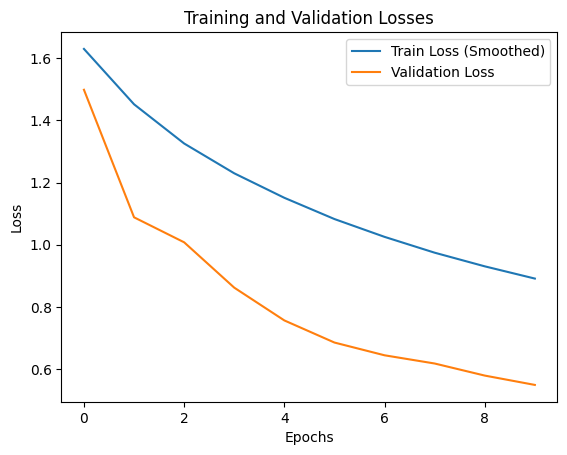

Training successful! Model achieved accuracy above 65%.


In [12]:
epochs = 10
lr = 1e-3
# TODO:

model = MobileNet(n_class=10)
model = model.to(device)

start_time = time.time()

train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)

accuracy = get_acc(model, val_loader) * 100

end_time = time.time()
training_time = end_time - start_time

print(f"Training completed in {training_time:.2f} seconds")
print(f"Validation Accuracy: {accuracy:.2f}%")

plot_losses(train_losses, val_losses)

if accuracy >= 65:
    print("Training successful! Model achieved accuracy above 65%.")
else:
    print("Training complete, but accuracy is below 65%. Consider tuning the hyperparameters.")

Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.8155
Process validation time: 27.0972 s


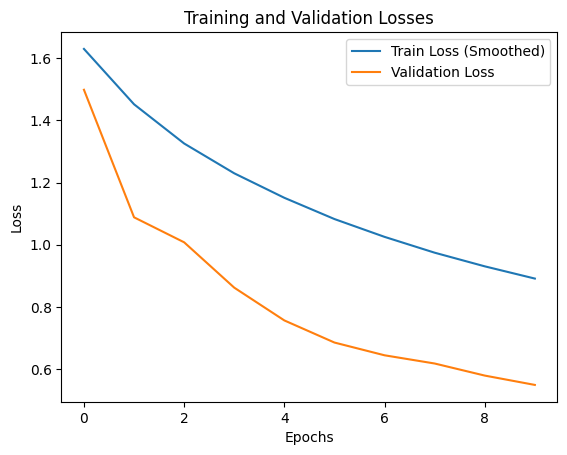

In [13]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.


This efficiency can be explained by comparing the number of **FLOPs (Floating Point Operations)** required for standard convolutions versus depthwise separable convolutions.

---

### **1. FLOPs for Standard Convolution**
For a standard convolution:
- Input feature map size: \( D_k * D_k * M \) (height, width, and channels)
- Kernel size: \( K * K \)
- Output feature map size: \( D_k * D_k * N \) (height, width, and channels)
- Number of parameters: \( K * K * M * N \)

**FLOPs for Standard Convolution:**

      F(standard) = K * K * M * N * D_k * D_k


---

### **2. FLOPs for Depthwise Separable Convolution**
Depthwise separable convolution consists of:
1. **Depthwise Convolution:**
   - Each input channel has its own filter ( K * K ).
   - Number of FLOPs:

          F(depthwise) = K * K * M * D_k * D_k


2. **Pointwise Convolution:**
   - A \( 1 * 1 \) kernel combines \( M \) input channels into \( N \) output channels.
   - Number of FLOPs:
     \[
     F_{pointwise} = M * N * D_k * D_k
     \]

**Total FLOPs for Depthwise Separable Convolution:**

      F (depthwise separable) = F(depthwise) + F(pointwise) = K * K * M * D_k * D_k + M * N * D_k * D_k


---

### **3. Comparison of FLOPs**
The ratio of FLOPs for depthwise separable convolution to standard convolution is:

      Reduction Factor = 1/N + 1/(K^1)


For a typical \( K = 3 \) (i.e., \( K^2 = 9 \)):

      Reduction Factor = 1/N + 1/9


For a large number of output channels ( N >> 1 ):

      Reduction Factor ≈ 1/9


This shows that depthwise separable convolutions require approximately **1/9th of the computation** of standard convolutions, making them 8 to 9 times faster.

## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [14]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()


        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [15]:
normal_cnn_model = NormalCNN(n_class=10)
normal_cnn_model = normal_cnn_model.to(device)

optimizer = torch.optim.Adam(normal_cnn_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_normal_cnn(model, train_loader, val_loader, epochs=2):
    start_time = time.time()
    for epoch in range(epochs):
        train_epoch_losses = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        train_loss = sum(train_epoch_losses) / len(train_epoch_losses)

        val_epoch_losses = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)
        val_loss = sum(val_epoch_losses) / len(val_epoch_losses)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training and validation completed in {training_time:.2f} seconds")
    return training_time

normal_cnn_training_time = train_normal_cnn(normal_cnn_model, train_loader, val_loader)

print(f"MobileNet Training Time: {training_time:.2f} seconds")
print(f"NormalCNN Training Time: {normal_cnn_training_time:.2f} seconds")

if normal_cnn_training_time > training_time:
    print(f"NormalCNN is slower by {normal_cnn_training_time - training_time:.2f} seconds.")
else:
    print(f"NormalCNN is faster by {training_time - normal_cnn_training_time:.2f} seconds.")


Epoch 1/2, Train Loss: 1.9306, Val Loss: 1.8031
Epoch 2/2, Train Loss: 1.7276, Val Loss: 1.5735
Training and validation completed in 339.39 seconds
MobileNet Training Time: 1069.50 seconds
NormalCNN Training Time: 339.39 seconds
NormalCNN is faster by 730.11 seconds.


Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.8155
Process validation time: 25.4144 s


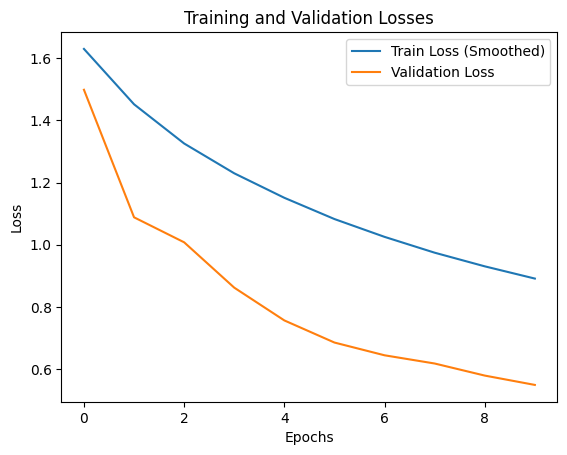

In [16]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Compare speed of learning and validating in normal CNN vs MobileNet

1. **Results:**
   - **MobileNet:** Training time for 10 epochs = **1069.50 seconds** (~107 seconds per epoch).
   - **NormalCNN:** Training time for 2 epochs = **339.39 seconds** (~169.7 seconds per epoch).

2. **Comparison:**
   - MobileNet is **faster per epoch** than NormalCNN, as it takes 107 seconds per epoch compared to NormalCNN's 169.7 seconds.
   - This aligns with the theoretical efficiency of MobileNet due to its use of **depthwise separable convolutions**, which significantly reduce computational requirements compared to the **standard convolutions** in NormalCNN.

3. **Conclusion:**
   - MobileNet demonstrates significantly faster training and validation speeds, making it more suitable for applications where computational efficiency is critical.

In [17]:
# TODO: compare number of parameters in these two models
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

mobilenet_params = count_parameters(model)
normal_cnn_params = count_parameters(normal_cnn_model)
print(f"Total number of Normal CNN parameters: {normal_cnn_params}")
print(f"Total number of MobileNet parameters: {mobilenet_params}")


Total number of Normal CNN parameters: 28279338
Total number of MobileNet parameters: 3217226


## 3.Transfer Learning
Now imagine that you have a well trained model of CIFAR10 and now you want to use transfer learning for a new task of classifying CIFAR100 dataset. in the next cell, you should load your good trained model with an accuracy of 80% on validation data from disk (you should have saved your good model). or use our model (model.pt) and use their parameters for a new model for classifying 100 classes.

In [18]:
model = MobileNet(n_class=100).to(device)

#Todo:

# Load the pre-trained weights for the layers that match (excluding the final fc layer)
pretrained_path = "model.pt"
pretrained_dict = torch.load(pretrained_path)

# Filter out unnecessary keys from the pretrained dict
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()}

# Load the updated state dict into the model
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)



<ipython-input-18-4466c6d60429>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(pretrained_path)


<All keys matched successfully>

**Freezing Layers** </br>
To make the best use of transfer learning, you should freeze the initial layers (usually up to the last few convolutional blocks) and only fine-tune the final layers. This way, the model retains most of the learned low-level features from CIFAR-10, while also adapting to CIFAR-100.

In MobileNet, it’s generally effective to freeze layers up to the point where the most complex, high-level features are computed, typically around the 7th or 8th convolutional block.

In [19]:
# Freeze up to the desired layer (e.g., the first 7 layers)

layers_to_freeze = 7
layer_count = 0

for child in model.model.children():
    if layer_count < layers_to_freeze:
        for param in child.parameters():
            param.requires_grad = False
    layer_count += 1

**Fine-tuning the Model** </br>

With the above setup, you can now train the model on CIFAR-100 using a lower learning rate. A good approach would be to:

Set a slightly lower learning rate (e.g., 1e-4) for the fine-tuning process.

But first get the dataset of CIFAR100.

In [20]:
# TRAIN DATA
train_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

indices = np.arange(20000)
train_set100 = Subset(train_set100, indices)

train_loader100 = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=True, num_workers=2)

# VALIDATION DATA
val_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

val_loader100 = torch.utils.data.DataLoader(
    val_set100, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 169M/169M [00:13<00:00, 12.8MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Now show 16 images of your data two times to see the images and how our data augmentaion worked. Also print labels to see the format.

Labels for the first batch: tensor([19, 29,  0, 11,  1, 86, 90, 28, 23, 31, 39, 96, 82, 17, 71, 39])


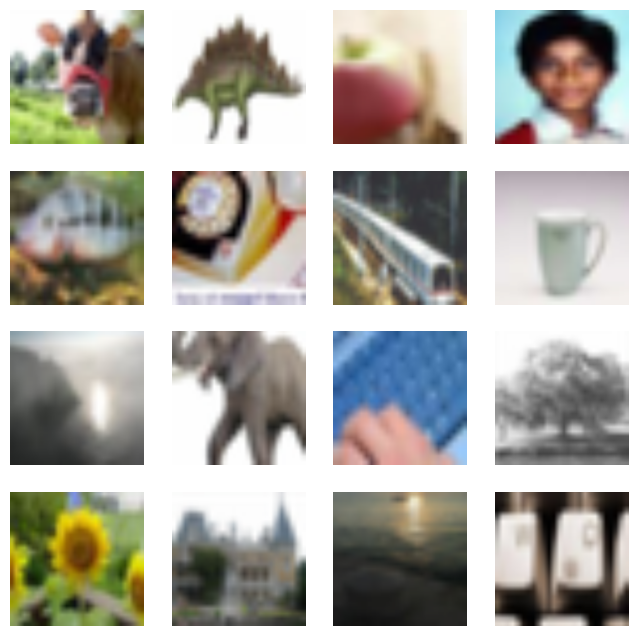

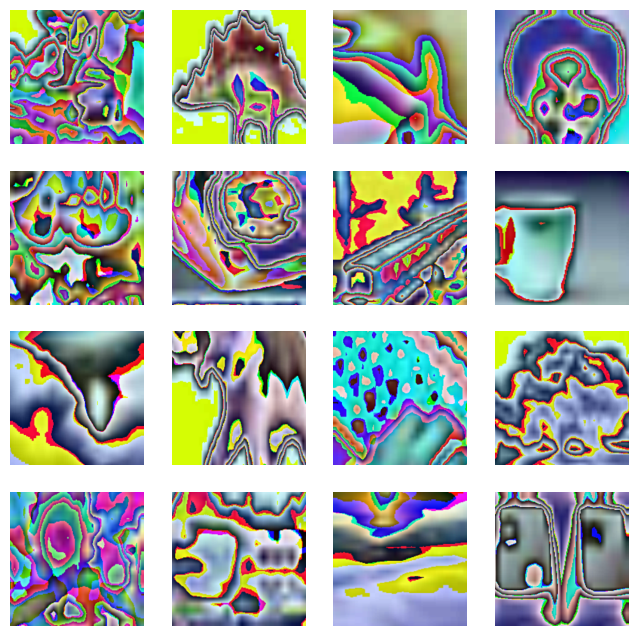

Labels remain unchanged: tensor([19, 29,  0, 11,  1, 86, 90, 28, 23, 31, 39, 96, 82, 17, 71, 39])


In [31]:
# show some training images with shuffle=False and labels
train_loader_no_shuffle = torch.utils.data.DataLoader(
    train_set100, batch_size=16, shuffle=False, num_workers=2
)

dataiter = iter(train_loader_no_shuffle)
images, labels = next(dataiter)

print("Labels for the first batch:", labels)
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    imshow(images[i])
plt.show()


# show them again to check the augmentation
augmented_images = torch.stack([transform_train(TF.to_pil_image(image)) for image in images])

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    imshow(augmented_images[i])
plt.show()

print("Labels remain unchanged:", labels)

Do CIFAR10 and CIFAR100 use the same images but with diffrent labesl?(maybe you should search)

**answer**

Now train your model using your functions.

In [32]:
epochs = 7
lr = 2e-4
train_losses, val_losses = train(train_loader100, val_loader100, model, epochs, lr)

Epoch 1/7, Train Loss: 3.9913735981959446, Val Loss: 3.404944718638553
Epoch 2/7, Train Loss: 3.2221316228246994, Val Loss: 2.9438322012937523
Epoch 3/7, Train Loss: 2.8578520231186206, Val Loss: 2.687509609174125
Epoch 4/7, Train Loss: 2.6245635512528147, Val Loss: 2.5005970574632475
Epoch 5/7, Train Loss: 2.443968769851004, Val Loss: 2.3723841739606253
Epoch 6/7, Train Loss: 2.3143754597682102, Val Loss: 2.272417071499402
Epoch 7/7, Train Loss: 2.2029830149024914, Val Loss: 2.1852123556257803


In [34]:
accuracy = get_acc(model, val_loader) * 100
print(f"val_acc = {accuracy}")

val_acc = 0.76


Get some metrics and plot your losses.

Batch_size=128, epochs=7, lr=0.0002
Val accuracy = 0.4116
Process validation time: 19.0995 s


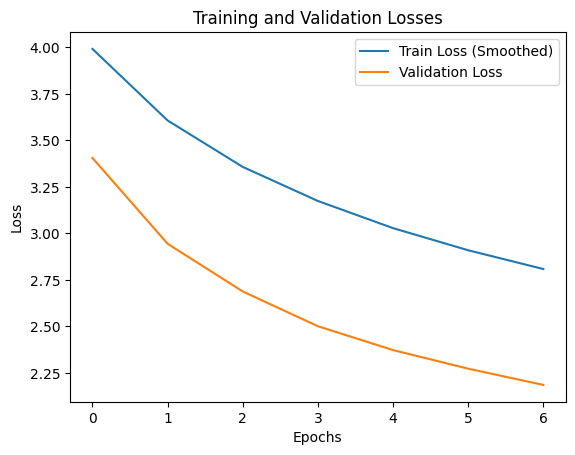

In [35]:
start = time.time()
val_acc = get_acc(model, val_loader100)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

## 4. MobileNet V2

### Theory
MobileNet V2 builds on the concepts of MobileNet V1, introducing two significant improvements:


- **Inverted Residuals**: One of the most notable features of MobileNet V2 is the use of inverted residual blocks. Unlike traditional residual blocks that connect layers of the same depth, inverted residuals connect layers with different depths, allowing for more efficient information flow and reducing computational complexity.
- **Linear Bottlenecks**: MobileNet V2 introduces linear bottlenecks between the layers. These bottlenecks help preserve the information by maintaining low-dimensional representations, which minimizes information loss and improves the overall accuracy of the model.
- **Depthwise Separable Convolutions**: Similar to MobileNet V1, MobileNet V2 employs depthwise separable convolutions to reduce the number of parameters and computations. This technique splits the convolution into two separate operations: depthwise convolution and pointwise convolution, significantly reducing computational cost.
- **ReLU6 Activation Function**: MobileNet V2 uses the ReLU6 activation function, which clips the ReLU output at 6. This helps prevent numerical instability in low-precision computations, making the model more suitable for mobile and embedded devices.

These innovations enable MobileNet V2 to achieve better accuracy with minimal increase in complexity, making it highly suitable for mobile applications.

You can learn more about MobileNetv2 [here](https://arxiv.org/abs/1801.04381).

One of the paper’s major contributions is the linear bottleneck. In deep learning, especially in low-dimensional spaces, using non-linear layers like ReLU after compressing data can cause important information to be lost. MobileNetV2 addresses this by using linear layers instead of ReLU in the bottleneck stages.


![lb](https://miro.medium.com/v2/resize:fit:720/format:webp/1*YGVXczC3hYtey2z-9MBkPw.png)


Another key innovation in MobileNetV2 is the inverted residual block. Unlike traditional residual blocks (such as those used in ResNet), which expand first and then compress, inverted residuals do the opposite. In MobileNetV2, the input is first compressed and then expanded back to the original dimensions.

![irb](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KyvQcI3Z8AxPpxjLpzrRdg.png)

As shown above, the inverted residual block (b) uses shortcuts, similar to those used in ResNet, but it compresses first and expands second, which makes it more efficient. This “inversion” allows for significant improvements in efficiency by reducing the number of operations required. To maintain performance, shortcuts (or skip connections) are used between the bottleneck layers, ensuring smooth gradient flow during training and preventing the loss of important information.

Now where are going to implement the model. First complete the below functions and class.

What is ReLU6 Activation Function? Why do we use that?

### **Definition**:

ReLU6 is a variation of the standard ReLU (Rectified Linear Unit) activation function, defined as:

ReLU6(x)=min(max(0,x),6)


### **Why Do We Use ReLU6?**

1. **Numerical Stability for Low-Precision Computations:**
   - In mobile and embedded systems, models often use low-precision arithmetic (e.g., 8-bit integers) to save memory and computation time.
   - ReLU6 restricts the activation values to the range \([0, 6]\), reducing numerical instability and overflow issues in low-precision environments.

2. **Efficient Gradient Flow:**
   - ReLU6 prevents excessively large gradients (as in regular ReLU where activations can grow unbounded).
   - This helps in stabilizing training and improving convergence.

3. **Saturation Property:**
   - The upper bound of \(6\) helps prevent large activations, which could lead to exploding gradients or unnecessary high precision requirements during inference.

4. **Compatibility with Mobile Devices:**
   - ReLU6 is specifically designed for mobile models like MobileNet, making it more hardware-friendly for mobile and embedded systems.

In [36]:

def conv_bn(inp, oup, stride):
    # Standard convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    # stride: stride for the convolution layer
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def conv_1x1_bn(inp, oup):
    # 1x1 pointwise convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        # Inverted Residual block with optional skip connection
        # inp: input channels
        # oup: output channels
        # stride: stride for depthwise convolution
        # expand_ratio: multiplier for the hidden dimension size

        super(InvertedResidual, self).__init__()

        # Determine if a skip connection should be used
        # (only used when stride is 1 and input channels == output channels)
        self.use_res_connect = (stride == 1 and inp == oup)

        # Calculate the number of hidden channels after expansion
        hidden_dim = inp * expand_ratio

        # If expand_ratio is 1, skip the initial pointwise convolution
        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # Depthwise convolution
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # Pointwise-linear convolution
                nn.Conv2d(hidden_dim, oup, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(oup)
            )

        else:
            self.conv = nn.Sequential(
                # Pointwise convolution to increase channel depth
                nn.Conv2d(inp, hidden_dim, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # Depthwise convolution
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # Pointwise-linear convolution to reduce channel depth
                nn.Conv2d(hidden_dim, oup, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(oup)
            )

    def forward(self, x):
        # Forward pass with optional residual connection
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

Now create the model using the image below. Please note that you should have the width_multiplier hyperparameter in your model. we will use it later.

![architecture](https://i.sstatic.net/1RAkv.png)

In [39]:
class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_multiplier=1.0):
        super(MobileNetV2, self).__init__()
        interverted_residual_setting = [# t, c, n, s
                                        [1, 16, 1, 1],
                                        [6, 24, 2, 2],
                                        [6, 32, 3, 2],
                                        [6, 64, 4, 2],
                                        [6, 96, 3, 1],
                                        [6, 160, 3, 2],
                                        [6, 320, 1, 1] ]
        input_channel = int(32 * width_multiplier)
        last_channel = int(1280 * width_multiplier) if width_multiplier > 1.0 else 1280

        # building first layer
        self.features = [conv_bn(3, input_channel, stride=2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_multiplier)
            for i in range(n):
                stride = s if i == 0 else 1
                self.features.append(InvertedResidual(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, last_channel))
        self.features.append(nn.AdaptiveAvgPool2d((1, 1)))

        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(nn.Linear(last_channel, n_class))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

How did you create linear bottlenecks? How do they help?


### **How Linear Bottlenecks Were Created**
Linear bottlenecks are implemented in the **`InvertedResidual`** block of the MobileNetV2 architecture. Here's how they were created:

1. **Pointwise Convolution (Expansion):**
   - The first step in the inverted residual block expands the number of channels by a factor (`expand_ratio`), introducing a higher-dimensional space for richer feature extraction.
   - This is done with a \(1 * 1\) pointwise convolution.

2. **Depthwise Convolution:**
   - A depthwise convolution processes each channel independently, capturing spatial relationships without increasing the number of parameters significantly.

3. **Pointwise Linear Convolution (Compression):**
   - The final step is a \(1 * 1\) pointwise **linear** convolution (without non-linear activation like ReLU).
   - This reduces the number of channels to the desired output, effectively acting as a bottleneck.

4. **Why Linear Convolution?**
   - Unlike regular convolution layers with non-linear activations (e.g., ReLU), the final bottleneck layer is **linear** to avoid loss of information caused by ReLU in low-dimensional spaces.

---

### **How Linear Bottlenecks Help**
1. **Avoiding Information Loss:**
   - In deep learning, non-linear activations like ReLU can destroy useful information in low-dimensional spaces (e.g., when features are compressed).
   - The linear bottleneck ensures the compressed representation retains all the important information while reducing channel dimensions.

2. **Efficient Feature Representation:**
   - By compressing channels, the linear bottleneck reduces the size of the intermediate representations, making the model more memory-efficient.

3. **Reduced Computational Cost:**
   - Reducing channel dimensions minimizes the number of computations required in subsequent layers, particularly in the pointwise convolution.

4. **Maintains Model Expressiveness:**
   - The higher-dimensional representation (via expansion) ensures the model can extract rich features, while the bottleneck compresses them efficiently without degrading performance.

---

Train your model with CIFAR10 dataset. Set the width_multiplier with value 1.

In [40]:
model = MobileNetV2(n_class=10).to(device)
epochs = 10
lr = 1e-3
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)


Epoch 1/10, Train Loss: 1.650000778610444, Val Loss: 1.5510356464203756
Epoch 2/10, Train Loss: 1.2976407946832955, Val Loss: 1.1127141611591267
Epoch 3/10, Train Loss: 1.1034623562832317, Val Loss: 1.0794748781592982
Epoch 4/10, Train Loss: 0.972533847060045, Val Loss: 0.9086314037347295
Epoch 5/10, Train Loss: 0.8787915561815052, Val Loss: 0.7918258730772954
Epoch 6/10, Train Loss: 0.8025247897485943, Val Loss: 0.7647861549808721
Epoch 7/10, Train Loss: 0.7465846481378121, Val Loss: 0.7045181175326086
Epoch 8/10, Train Loss: 0.6984958532826065, Val Loss: 0.692258916652886
Epoch 9/10, Train Loss: 0.6570109539019787, Val Loss: 0.6321848786560593
Epoch 10/10, Train Loss: 0.6263038742420314, Val Loss: 0.6209553461165944


Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.7919
Process validation time: 27.6268 s


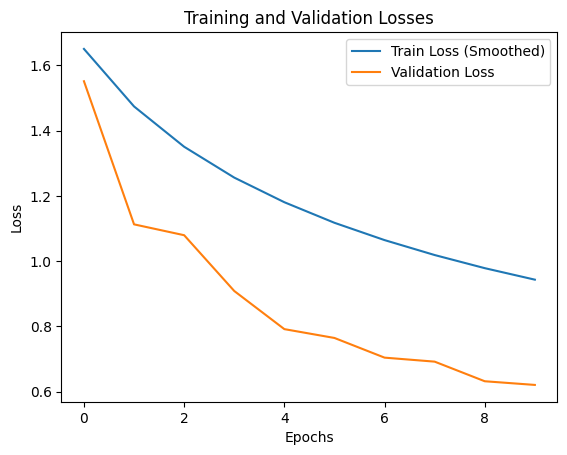

In [41]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Now we want to see the effect of the hyperparameter (width multiplier) in our model. For all values between 0.1 to 1 with step 0.1 print the number of parameters.

In [42]:
# TODO

for width_multiplier in [i / 10 for i in range(1, 11)]:
    model = MobileNetV2(n_class=10, width_multiplier=width_multiplier)

    num_params = count_parameters(model)

    print(f"With {width_multiplier:.1f} width multiplier we got {num_params} parameters.")

With 0.1 width multiplier we got 81943 parameters.
With 0.2 width multiplier we got 183048 parameters.
With 0.3 width multiplier we got 318444 parameters.
With 0.4 width multiplier we got 487958 parameters.
With 0.5 width multiplier we got 697258 parameters.
With 0.6 width multiplier we got 931391 parameters.
With 0.7 width multiplier we got 1203792 parameters.
With 0.8 width multiplier we got 1510396 parameters.
With 0.9 width multiplier we got 1851206 parameters.
With 1.0 width multiplier we got 2236682 parameters.


Now load the pretrained model that we trained with width_multiplier=1/2 for 15 epoches. then compare it's accuracy and time it needs for validation data with normal MobileNetv2 model.

In [47]:
MNv2_path = './MNv2WMmodel.pt'
# TODO
pretrained_model = MobileNetV2(n_class=10, width_multiplier=0.5)
state_dict = torch.load(MNv2_path)

new_state_dict = pretrained_model.state_dict()
filtered_state_dict = {k: v for k, v in state_dict.items() if k in new_state_dict and v.size() == new_state_dict[k].size()}

pretrained_model.load_state_dict(filtered_state_dict, strict=False)

pretrained_model = pretrained_model.to(device)

start = time.time()
val_acc_pretrained = get_acc(pretrained_model, val_loader)
end = time.time()

print('Pretrained MobileNetV2 (width_multiplier=0.5) validation accuracy =', val_acc_pretrained)
print("Validation time for pretrained model: {:0.4f} s".format(end - start))

<ipython-input-47-14e3673442cf>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MNv2_path)


Pretrained MobileNetV2 (width_multiplier=0.5) validation accuracy = 0.1022
Validation time for pretrained model: 24.0704 s


In [49]:
start = time.time()
val_acc = get_acc(pretrained_model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))



Val accuracy = 0.1022
Process validation time: 23.8898 s


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.

- **Formula:** The width multiplier (alpha) scales the number of input and output channels in each layer:
      New params = alpha^2 * original params
- **Effect on Parameters:**
  - When (alpha = 0.5), the number of parameters reduces to ((0.5)^2 = 0.25) or 25% of the original.
  - If theoretical and observed numbers differ, it's due to layers not affected by (alpha) (e.g., batch norm, classifier layers).


Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

- **Speed:** The resolution multiplier reduces the spatial size of the input image, leading to fewer operations in convolutional layers:

      Operations ∝ Height * Width

  This makes the model faster.
- **Number of Parameters:** The resolution multiplier does **not** affect the number of parameters since the architecture (e.g., channels, filters) remains unchanged.

Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?

- **Why Parameters Matter:**
  - Fewer parameters mean lower memory usage and faster inference, which is critical for mobile and edge devices.
  - Smaller models consume less power, important for battery-powered devices.

- **But We Have GPUs:**
  - While GPUs accelerate training and inference, parameters are still important for:
    - **Edge Devices:** Limited resources
    - **Energy Efficiency:** Lower power consumption is critical.
    - **Real-Time Applications:** Smaller models reduce latency.

## 5.Knowledge Distillation

Now we learn how you can implement knowledge distillation using a pre-trained ResNet as the teacher model and MobileNetV2 as the student model for the CIFAR-10 dataset.

Knowledge distillation is a process where a smaller, more efficient model (the student) is trained to replicate the behavior of a larger, more complex model (the teacher). This is particularly useful for deploying models on resource-constrained devices where efficiency and speed are critical.

You can learn more about the loss function we use for this porpuse [here](
https://medium.com/@aryamaanthakur/knowledge-distillation-make-your-neural-networks-smaller-398485f811c6)

First create our teacher.(Pay attention that we need to finetune this teacher for out task, but because of lack of resources we will just use it with terrible accuracy)

In [55]:
import timm

# Load a pre-trained ResNet18 fine-tuned on CIFAR-10
teacher_model = timm.create_model('resnet18', pretrained=True, num_classes=10)
teacher_model = teacher_model.to(device)

In [56]:
start = time.time()
val_acc = get_acc(teacher_model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))


Val accuracy = 0.0864
Process validation time: 26.1429 s


Now create a mobilenetv2 model and then write the code to train it with Knowledge Distillation.

In [57]:
class DistillationLoss(nn.Module):
    """
    Custom loss function for knowledge distillation combining KL divergence
    and cross-entropy loss.

    Args:
        temperature (float): Temperature parameter for scaling logits.
        alpha (float): Weighting factor for distillation and classification loss.
    """
    def __init__(self, temperature: float = 3.0, alpha: float = 0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction="batchmean")
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self,
                student_logits: torch.Tensor,
                teacher_logits: torch.Tensor,
                labels: torch.Tensor) -> torch.Tensor:
        """
        Compute the combined distillation and classification loss.

        Args:
            student_logits (torch.Tensor): Logits from the student model.
            teacher_logits (torch.Tensor): Logits from the teacher model.
            labels (torch.Tensor): Ground truth labels.

        Returns:
            torch.Tensor: The computed loss value.
        """
        student_logits_t = student_logits / self.temperature
        teacher_logits_t = teacher_logits / self.temperature

        distillation_loss = self.kl_div(
            nn.functional.log_softmax(student_logits_t, dim=1),
            nn.functional.softmax(teacher_logits_t, dim=1)
        ) * (self.temperature ** 2)

        classification_loss = self.ce_loss(student_logits, labels)

        loss = self.alpha * distillation_loss + (1 - self.alpha) * classification_loss
        return loss


def train_student(teacher: nn.Module,
                  student: nn.Module,
                  train_loader: torch.utils.data.DataLoader,
                  test_loader: torch.utils.data.DataLoader,
                  device: torch.device,
                  epochs: int = 10,
                  lr: float = 0.01) -> None:
    """
    Train a student model using knowledge distillation.

    Args:
        teacher (nn.Module): Pre-trained teacher model.
        student (nn.Module): Student model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        test_loader (torch.utils.data.DataLoader): DataLoader for test data.
        device (torch.device): Device to perform training on (CPU or GPU).
        epochs (int): Number of training epochs. Default is 10.
        lr (float): Learning rate for the optimizer. Default is 0.01.
    """
    teacher.to(device).eval()
    student.to(device)

    criterion = DistillationLoss(temperature=3.0, alpha=0.5)
    optimizer = optim.Adam(student.parameters(), lr=lr)

    for epoch in range(epochs):
        student.train()
        epoch_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.no_grad():
                teacher_logits = teacher(inputs)

            student_logits = student(inputs)

            loss = criterion(student_logits, teacher_logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

        student.eval()
        val_acc = get_acc(student, test_loader)
        print(f"Validation Accuracy: {val_acc:.4f}")


Train it for one epoch to just check if it works.

In [58]:
student = MobileNetV2(n_class=10)

train_student(teacher_model, student, train_loader, val_loader, device, epochs=1, lr=0.001)

Epoch [1/1], Loss: 0.9983
Validation Accuracy: 0.4378


What are the potential trade-offs of using a high value of alpha (e.g., 0.9) versus a low value of alpha (e.g., 0.1) in the DistillationLoss? How might these trade-offs impact the student model's performance in terms of generalization to the target task and alignment with the teacher's knowledge?


### **Trade-Offs of High Alpha (e.g., 0.9) vs. Low Alpha (e.g., 0.1)**

The alpha parameter in **DistillationLoss** controls the balance between:
1. **Distillation Loss (KL Divergence):** Encourages the student to mimic the teacher’s knowledge.
2. **Classification Loss (Cross-Entropy):** Focuses the student on aligning with the true labels.

#### **1. High Alpha (e.g., 0.9):**
- **Pros:**
  - Strongly emphasizes the **teacher’s knowledge** (soft labels).
  - Helps the student model learn more nuanced patterns and inter-class relationships captured by the teacher.
  - Can be beneficial for tasks where the teacher’s output is significantly more reliable than the dataset labels.

- **Cons:**
  - The student may overfit to the teacher’s knowledge, which might include biases or errors in the teacher’s predictions.
  - Reduces the student’s ability to learn directly from the true labels, potentially harming generalization to unseen data.
  - If the teacher is poorly tuned for the specific task, high alpha can mislead the student.

---

#### **2. Low Alpha (e.g., 0.1):**
- **Pros:**
  - Prioritizes learning directly from the true labels (classification loss).
  - Ensures the student focuses on the target task, which can improve generalization when the dataset labels are highly accurate.
  - Minimizes reliance on the teacher, making it useful when the teacher’s predictions are suboptimal.

- **Cons:**
  - Reduces the influence of the teacher’s knowledge, losing the benefit of the teacher’s inter-class relationships and smoother probability distribution.
  - The student may lack the richer representation power provided by the teacher.

---
#### **Conclusion:**
- **High Alpha:** Best for leveraging a well-trained teacher that is highly accurate and generalizes well. Suitable when the dataset is small or noisy.
- **Low Alpha:** Preferable when the dataset labels are highly reliable or the teacher’s predictions are suboptimal for the target task.

## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.
- **MobileNet V2**: Added inverted residuals and linear bottlenecks to improve efficiency and performance, reducing memory use without sacrificing accuracy.

These architectures are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

question for yourself: What new features and innovations did MobileNetV3 introduce to improve both efficiency and accuracy over its predecessors? Explore its design choices and how they further optimize MobileNet for real-time applications and mobile deployment.

## Refrences

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017

[2] Mark Sandler, Andrew G. Howard, Menglong Zhu, Andrey
Zhmoginov, and Liang-Chieh Chen. Mobilenetv2: Inverted
residuals and linear bottlenecks. mobile networks for classification, detection and segmentation. CoRR, abs/1801.04381,
2018